# Урок 1. Введение в PyTorch

Используя файл Web1.ipynb добиться хорошего результата от модели, собранной на занятии (6 угаданныx картинок из 8 предложенных).  

Варианты изменений:  
- изменение слоёв и их количества;  
-  изменение метода оптимизации;  
-  изменение процесса обучения

In [1]:
from IPython import display
import numpy as np
import random

import torch
import torchvision
from torch import nn 
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Загрузка данных**

In [3]:
# Загрузка данных train_dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='data/',  # путь, куда будут скачиваться данные(если download=true), 
                   # или где лежат данные(dowload=False)
    train=True,    # говорим что используем датасет для обучения  
    transform=transforms.ToTensor(), # преобразуем данные в формат тензоров
    download=True
)


image, label = train_dataset[0]
print(image.shape)
print(label)

Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [4]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
image.permute(1, 2, 0).shape

torch.Size([32, 32, 3])

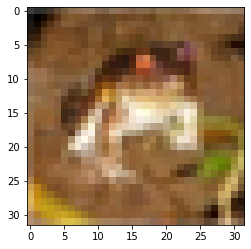

In [6]:
plt.imshow(image.permute(1, 2, 0))

In [7]:
# Даталоадер
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64, 
    shuffle=True
)

torch.Size([64, 3, 32, 32]) torch.Size([64])
car


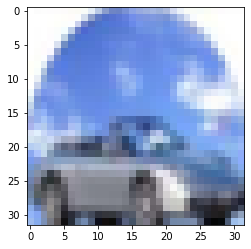

In [8]:
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)
    print(classes[labels[0]])
    plt.imshow(imgs[0].permute(1, 2, 0))
    break

In [9]:
# Загрузка данных test_dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

Files already downloaded and verified


**Реализация классификационной сети**

In [10]:
# Определим модель

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=3) # < --- ИЗМЕНЕН KERNEL_SIZE
        self.pool = nn.MaxPool2d(kernel_size=2,
                                 stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=3) # < --- ИЗМЕНЕН KERNEL_SIZE
        # --- ИЗМЕНЕНО КОЛ-ВО СЛОЕВ ---
        self.conv3 = nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3)
        self.fc1 = nn.Linear(in_features=32 * 2 * 2,
                             out_features=120)
        
        self.fc2 = nn.Linear(in_features=120,
                             out_features=60)
        self.fc3 = nn.Linear(in_features=60,
                             out_features=30)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.reshape(-1, 32 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#     class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3,
#                                out_channels=6,
#                                kernel_size=5)
#         self.pool = nn.MaxPool2d(kernel_size=2,
#                                  stride=2)
#         self.conv2 = nn.Conv2d(in_channels=6,
#                                out_channels=16,
#                                kernel_size=5)
#         self.fc1 = nn.Linear(in_features=16 * 5 * 5,
#                              out_features=120)
#         self.fc2 = nn.Linear(in_features=120,
#                              out_features=84)
#         self.fc3 = nn.Linear(in_features=84,
#                              out_features=10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.reshape(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
net = Net()

In [11]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=30, bias=True)
)

In [12]:
# Метод оптимизации
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) # <--- ИЗМЕНЕН МЕТОД ОПТИМИЗАЦИИ

In [13]:
%%time
num_epochs = 15 # < --- ИЗМЕНЕНО КОЛ-ВО ЭПОХ

for epoch in range(num_epochs):
    running_loss = 0.0  # Для вывода процесса обучения
    running_items = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/15]. Step [1/782]. Loss: 0.053
Epoch [1/15]. Step [301/782]. Loss: 0.036
Epoch [1/15]. Step [601/782]. Loss: 0.031
Epoch [2/15]. Step [1/782]. Loss: 0.027
Epoch [2/15]. Step [301/782]. Loss: 0.027
Epoch [2/15]. Step [601/782]. Loss: 0.025
Epoch [3/15]. Step [1/782]. Loss: 0.021
Epoch [3/15]. Step [301/782]. Loss: 0.024
Epoch [3/15]. Step [601/782]. Loss: 0.023
Epoch [4/15]. Step [1/782]. Loss: 0.024
Epoch [4/15]. Step [301/782]. Loss: 0.022
Epoch [4/15]. Step [601/782]. Loss: 0.022
Epoch [5/15]. Step [1/782]. Loss: 0.019
Epoch [5/15]. Step [301/782]. Loss: 0.021
Epoch [5/15]. Step [601/782]. Loss: 0.021
Epoch [6/15]. Step [1/782]. Loss: 0.022
Epoch [6/15]. Step [301/782]. Loss: 0.020
Epoch [6/15]. Step [601/782]. Loss: 0.020
Epoch [7/15]. Step [1/782]. Loss: 0.017
Epoch [7/15]. Step [301/782]. Loss: 0.020
Epoch [7/15]. Step [601/782]. Loss: 0.020
Epoch [8/15]. Step [1/782]. Loss: 0.021
Epoch [8/15]. Step [301/782]. Loss: 0.019
Epoch [8/15]. Step [601/782]. Loss: 0.019
Epoch [9

**Сохранение модели**

In [14]:
PATH_WEIGHTS = './data/cifar_net_test_version_weights.pth'
torch.save(net.state_dict(), PATH_WEIGHTS)

In [15]:
print("Model state_dict: ")
for param in net.state_dict():
    print(param, "\t", net.state_dict()[param].size())

Model state_dict: 
conv1.weight 	 torch.Size([6, 3, 3, 3])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 3, 3])
conv2.bias 	 torch.Size([16])
conv3.weight 	 torch.Size([32, 16, 3, 3])
conv3.bias 	 torch.Size([32])
fc1.weight 	 torch.Size([120, 128])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([60, 120])
fc2.bias 	 torch.Size([60])
fc3.weight 	 torch.Size([30, 60])
fc3.bias 	 torch.Size([30])


In [16]:
PATH_MODEL = './data/cifar_net_test_version_model.pth'
torch.save(net, PATH_MODEL)

**Загрузка модели**

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH_WEIGHTS))
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=30, bias=True)
)

In [18]:
net = torch.load(PATH_MODEL)
net.to('cpu')

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=30, bias=True)
)

In [19]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

GroundTruth:  cat ship ship plane frog frog car frog


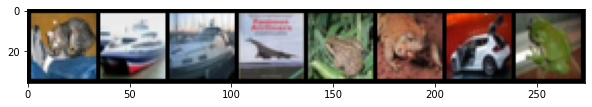

In [20]:
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [21]:
print(outputs)

tensor([[ -1.9593,  -2.0003,   0.5104,   4.3758,   0.6674,   2.2235,   1.3327,
           0.3940,   2.1842,  -1.9554, -15.2855, -14.8410, -15.9320, -15.0322,
         -15.4690, -15.0913, -16.0697, -13.7544, -15.0243, -15.0149, -14.2323,
         -15.3682, -15.6978, -14.1212, -15.3969, -15.3588, -15.4389, -15.3595,
         -15.7360, -15.0507],
        [  4.4882,   6.3959,  -3.3493,  -2.8817,  -2.4841,  -3.8858,  -4.8986,
          -4.2451,   7.9928,   4.9391, -40.1046, -39.6222, -41.3615, -41.4342,
         -41.6116, -38.8875, -40.5439, -36.2846, -41.1049, -39.7506, -37.9056,
         -37.9276, -43.8678, -39.1682, -40.2232, -41.3279, -42.2016, -39.3645,
         -39.9622, -40.2828],
        [  2.5383,   3.0296,  -1.1585,  -0.9325,  -1.1118,  -2.2160,  -2.6723,
          -1.5723,   3.8394,   2.6559, -22.0821, -21.9620, -22.6456, -22.9188,
         -22.8560, -21.5803, -22.4347, -20.1331, -22.4551, -22.0771, -20.7994,
         -20.9910, -23.9790, -21.4286, -22.2128, -22.9365, -23.1592, -2

In [22]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([3, 8, 8, 0, 4, 3, 1, 6])

In [23]:
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

Predicted:  cat ship ship plane deer cat car frog


In [24]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'ship' 'plane' 'deer' 'cat' 'car' 'frog']
Accuracy is 0.75
